# Imports

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

# Diabetes

In [8]:
loading = pickle.load(open("datasets/diabetes5000.p", "rb"))

In [24]:
ordering = loading[0] # features numbers in order of their informativeness
sample_sizes = loading[1] # np.array of size 350 with different sample sizes
means = loading[2] # list of log-likelihood (or -loss) means for sample sizes in SampleStep for different number of features (from 1 to 10)
stds = loading[3] # list of log-likelihood (or -loss) stds for sample sizes in SampleStep for different number of features (from 1 to 10)
X_train = loading[4] # np.array of shape(361, 10) with training data
y_train = loading[5] # np.array of size 361 with training target
X_test = loading[6] # np.array of shape(81, 10) with testing data
y_test = loading[7] # np.array of size 81 with testing target

# Functions

Попробуем аппроксимировать график функции ошибки (я так и не понял, что это конкретно, -loss / llh), чтобы, зная только небольшой объем $m_0$ обучающей выборки, делать предсказание того самого $m^* > m_0$, при котором наклон рассматриваемого графика был небольшим (или какое-нибудь другое условие по типу небольших значений дисперсии).

Аппроксимировать можно как среднее значение функции ошибки, так и ее дисперсию, посчитанную с помощью bootstrap.

1. Аппроксимация среднего значения
$$ \mathrm{mean}(m) \approx w_0 - w_1^2 \cdot \exp\left( -w_2^2 \cdot m \right) - \dfrac{w_3^2}{m^{3/2}}$$

In [25]:
def func_1D_mean_approx(m, w):
    """
    Parameters
    ----------
    m: int
        Variable - available sample size
    w: array-like
        Parameter - Parameters of function approximation
    
    Returns
    -------
    Scalar function approximation at point m, i.e. f(m)
    """
    return w[0] - (w[1]**2)*np.exp(-(w[2]**2)*m) - (w[3]**2)/(m**1.5)

2. Аппроксимация дисперсии

$$ \mathrm{std}(m) \approx w_1^2 \cdot \exp\left( - w_2^2 \cdot m \right) + \dfrac{w_3^2}{m^{3/2}} $$

In [26]:
def func_1D_var_approx(m, w):
    """
    Parameters
    ----------
    m: int
        Variable - available sample size
    w: array-like
        Parameter - Parameters of function approximation
    
    Returns
    -------
    Scalar function approximation at point m, i.e. f(m)
    """
    return (w[1]**2)*np.exp(-(w[2]**2)*m)+(w[3]**2)/(m**1.5)

In [27]:
# sample_sizes_available - np.array with different sample sizes
# means - list of log-likelihood (or -loss) means for sample sizes in sample_sizes_available for different number of features
# sample_sizes_approximation - np.array with different sample sizes for approximation
# n - dim of parameters vector w
# M - number of first sample sizes from SampleStep
# verbose - whether or not to use tqdm
# func - function to approximate the mean of log-likelihood
# w0s - list with initial points for optimizing parameters w
def mean_approx(sample_sizes, means, sample_sizes_approximation, func=func_1D_mean_approx, n=4, w0s=None, M=None, verbose=False):

    # list with approximations of log-likelihood means
    means_approximation = []
    # list for estimated parameters w
    ws = []
    # initial points for optimizing parameters w
    w0s = [np.random.normal(size=n) for _ in range(len(means))] if w0s is None else w0s
    
    # zip arrays means and w0s
    iterator = zip(means, w0s)
    iterator = tqdm(iterator) if verbose == True else iterator
        
    for mean, w0 in iterator:
        
        if M is not None: # use only first M sample sizes from SampleStep to optimize w
                          # that is we can know less samples than can estimate
            X_train = sample_sizes[0:M]
            y_train = mean[0:M]
        else:
            X_train = sample_sizes
            y_train = mean
        
        # find parameters w, that minimize MSE between log-likelihood (-loss) mean and it's approximation
        # start optimizing from w = w0
        # по сути просто идет аппроксимация одномерной функции на отрезке, тут ничего сложного
        minimum = minimize(lambda w: ((func(X_train, w) - y_train)**2).sum(), w0)

        # append means_approximation with log-likelihood mean approximation
        means_approximation.append(func(sample_sizes_approximation, minimum.x))

        # append List_of_w with optimal parameters w
        ws.append(minimum.x)

    return means_approximation, ws

In [28]:
def get_graph(sample_sizes, means, sample_sizes_approximation, Ms=None, N=100, func=func_1D_mean_approx, n=4, w0s=None, verbose=False):

    means_matrix = []
    stds_matrix = []
    
    iterator = tqdm(Ms) if verbose == True else Ms
    
    for M in iterator:

        tmp = []

        for _ in range(N):

            means_approximation, _ = mean_approx(sample_sizes, means, sample_sizes_approximation, func, n, w0s, M, verbose)
            tmp.append(means_approximation)
        
        tmp = np.array(tmp)
        
        means_matrix.append(np.mean(tmp, axis=0))
        stds_matrix.append(np.std(tmp, axis=0))
        
    return means_matrix, stds_matrix

# Some shit

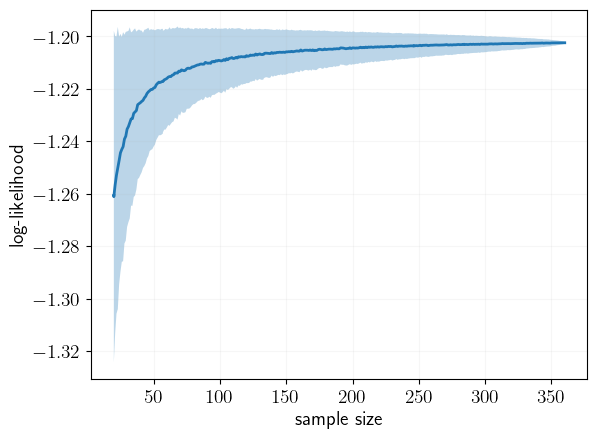

In [29]:
#N = 0 # number of features = 1
N = 6

means = np.array(means[N])
stds = np.array(stds[N])

plt.plot(sample_sizes, means)
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)

plt.xlabel('sample size')
plt.ylabel('log-likelihood')

plt.show()

In [19]:
l = 26
n = 4

In [124]:
Ms = [50 - l, 100 - l, 150 - l, 200 - l, 250 - l, 300 - l]

sample_sizes_approximation = np.linspace(l, 500, 100, dtype=np.int64)

means_matrix, stds_matrix = get_graph(
    sample_sizes=sample_sizes, 
    means=means, 
    sample_sizes_approximation=sample_sizes_approximation, 
    Ms=Ms, 
    N=100, 
    func=func_1D_mean_approx, 
    n=n, 
    w0s=None, 
    verbose=True
)

means_matrix = np.array(means_matrix)
stds_matrix = np.array(stds_matrix)

9it [00:00, 58.07it/s]00:00<?, ?it/s]
9it [00:00, 92.78it/s]
9it [00:00, 103.45it/s]
9it [00:00, 94.74it/s]
9it [00:00, 97.82it/s]
9it [00:00, 84.12it/s]
9it [00:00, 83.33it/s]
9it [00:00, 111.11it/s]
9it [00:00, 62.07it/s]
9it [00:00, 59.21it/s]
9it [00:00, 69.23it/s]
9it [00:00, 120.00it/s]
9it [00:00, 64.75it/s]
9it [00:00, 62.94it/s]
9it [00:00, 83.33it/s]
9it [00:00, 125.00it/s]
9it [00:00, 67.17it/s]
9it [00:00, 65.22it/s]
9it [00:00, 84.91it/s]
9it [00:00, 91.84it/s]
9it [00:00, 125.00it/s]
9it [00:00, 155.18it/s]
9it [00:00, 132.36it/s]
9it [00:00, 52.94it/s]
9it [00:00, 109.76it/s]
9it [00:00, 70.87it/s]
9it [00:00, 87.39it/s]
9it [00:00, 136.37it/s]
9it [00:00, 63.38it/s]
9it [00:00, 155.18it/s]
9it [00:00, 62.94it/s]
9it [00:00, 55.22it/s]
9it [00:00, 37.50it/s]
9it [00:00, 55.22it/s]
9it [00:00, 69.23it/s]
9it [00:00, 69.77it/s]
9it [00:00, 67.67it/s]
9it [00:00, 66.67it/s]
9it [00:00, 56.25it/s]
9it [00:00, 84.91it/s]
9it [00:00, 128.58it/s]
9it [00:00, 74.38it/s]
9it [00:

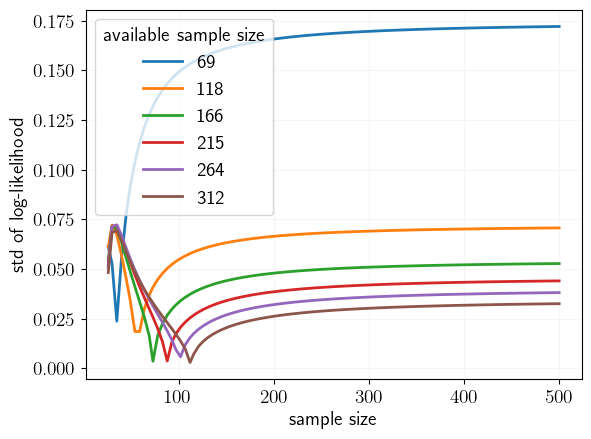

In [125]:
N = 0 # number of features = 1

for i in range(stds_matrix.shape[0]):
    std = np.sqrt(stds_matrix[i, N])
    plt.plot(sample_sizes_approximation, std, label = str(sample_sizes[Ms[i]] + l))

plt.legend(title='available sample size')
plt.xlabel('sample size')
plt.ylabel('std of log-likelihood')

plt.show()

In [20]:
#N = 0 # number of features = 1
N = 8

for i in range(means_matrix.shape[0]):
    mean = means_matrix[i, N]
    plt.plot(sample_sizes_approximation, mean, label = str(sample_sizes[Ms[i]] + l))
    
mean = np.array(means[N])
std = np.array(stds[N])

plt.plot(sample_sizes, mean, color='black', linestyle='dashed', label = 'original')

plt.legend(title='available sample size')
plt.xlabel('sample size')
plt.ylabel('log-likelihood')

plt.show()

NameError: name 'means_matrix' is not defined